#### using the synthetic data from Misha. Quick validating of Unet

In [1]:
!pip install mrcfile

In [2]:
# data loading
import os
import mrcfile
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from tqdm import tqdm  # ! this might result into problem with 'object'

In [3]:
def readMRC(path):
    with mrcfile.open(path, mode='r+', permissive=True) as mrc:
        mrc.header.map = mrcfile.constants.MAP_ID # for synthetic data, need to generate ID
        data = mrc.data
    return data

In [4]:
DATA_PATH = 'F:/MDC/4.1dataAugNeat/EM/3dem/data/interim/synthetic/'
data_ids = next(os.walk(DATA_PATH))[1]

In [5]:
import os
import pandas as pd
raw = []
for n, id_ in tqdm(enumerate(data_ids), total=len(data_ids)):  
    path = DATA_PATH + id_
    datanames = os.listdir(path)
    for dataname in datanames:
        if os.path.splitext(dataname)[1] == '.mrc':#目录下包含.mrc的文件
            temp = readMRC(path + "/" + dataname).astype(np.uint8)
            raw.append(temp)
            print(dataname)
            
focal = raw[0:3]
GT = raw[3:len(raw)]
del raw, temp, datanames, dataname, path, data_ids, n, id_

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]E:\INSTALL\anaconda\envs\seg\lib\site-packages\mrcfile\mrcinterpreter.py:219: RuntimeWarning: Unrecognised machine stamp: 0x00 0x00 0x00 0x00
  warnings.warn(str(err), RuntimeWarning)
 50%|██████████████████████████████████████████                                          | 1/2 [00:00<00:00,  5.79it/s]

tomo1_focalseries.mrc
tomo2_focalseries.mrc
tomo3_focalseries.mrc
tomo1_groundtruth.mrc
tomo2_groundtruth.mrc


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.05it/s]

tomo3_groundtruth.mrc


uint8


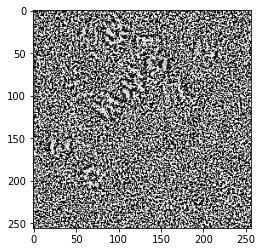

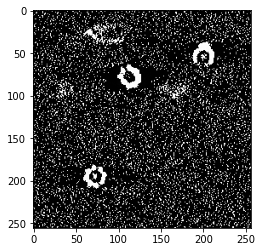

In [13]:
# sanity check for the data
import random
testF = focal[0]
testF.shape

testIm = testF[random.randint(0, testF.shape[0]),...]
print(testF.dtype)
plt.figure('focal');plt.imshow(testIm, cmap='gray')

testGT = GT[0]
testGT.shape

testIm = testGT[random.randint(0,testGT.shape[0]),...]
plt.figure();plt.imshow(testIm, cmap='gray')

In [51]:
# select the firt two (focal+ GT) as training, third as testing
import torchio as tio
from patchify import patchify, unpatchify

# training dataset
train_raw = np.vstack(([focal[0], focal[1]]));train = train_raw[...,np.newaxis].transpose((3,1,2,0)); label = np.vstack(([GT[0], GT[1]]))#;label = train_label[...,np.newaxis]
print(train_raw.shape)
# padding into the same size
trainIO = tio.ScalarImage(tensor=train)
target_shape = 256,256,512
crop_pad = tio.CropOrPad(target_shape, padding_mode='mean'); resized = crop_pad(trainIO) # padding with mean
train_padd = resized.numpy().transpose((3,1,2,0)); train_padd = train_padd[...,0]
print(train_padd.shape);print(label.shape)

(202, 256, 256)
(512, 256, 256)
(512, 256, 256)


In [89]:
# testing dataset
X_test = focal[2]/ 255.; X_test = X_test[...,np.newaxis].transpose((3,1,2,0))
Y_test_label = GT[2] / 255.; Y_test_label = (Y_test_label > 0.5).astype(np.float) 

testIO = tio.ScalarImage(tensor=X_test)
target_shape = 256,256,256
crop_pad = tio.CropOrPad(target_shape, padding_mode='mean'); resized = crop_pad(testIO)
test_padd = resized.numpy().transpose((3,1,2,0)); X_test_padd = test_padd[...,0];
print(X_test_padd.shape);
print(Y_test_label.shape)

# need to be patchified

(256, 256, 256)
(256, 256, 256)


E:\INSTALL\anaconda\envs\seg\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


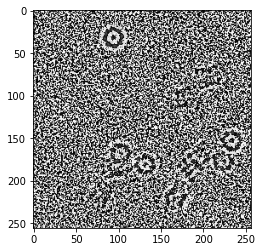

In [21]:
# sanity check
test = train_padd[256,...]
plt.imshow(test,cmap='gray')

In [78]:
# pacthify the image stacks
from patchify import patchify
all_img_patches = []

for img in range(train_padd.shape[0]):
    large_image = train_padd[img]
    
    patches_img = patchify(large_image, (128, 128), step=128)  # no overlap
    

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            
            single_patch_img = patches_img[i,j,:,:]
            single_patch_img = (single_patch_img.astype('float32')) / 255.  # remember to standarize into 0-1
                  
            all_img_patches.append(single_patch_img)

images = np.array(all_img_patches)

#Convert grey image to 3 channels by copying channel 3 times.
#We do this as our unet model expects 3 channel input. 
images = np.stack((images,)*3, axis=-1)

# generate small patches for masks
all_mask_patches = []
for img in range(label.shape[0]):
     
    large_mask = label[img]
    
    patches_mask = patchify(large_mask, (128, 128), step=128)  
    

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):
            
            single_patch_mask = patches_mask[i,j,:,:]
            single_patch_mask = single_patch_mask / 255.
            
            all_mask_patches.append(single_patch_mask)

masks = np.array(all_mask_patches)
masks = np.expand_dims(masks, -1)
masks = (masks > 0.5).astype(np.float) # binarize the data

print(masks.shape) # masks for training
print(images.shape)  # image patches for training

(2048, 128, 128, 1)
(2048, 128, 128, 3)


E:\INSTALL\anaconda\envs\seg\lib\site-packages\ipykernel_launcher.py:44: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


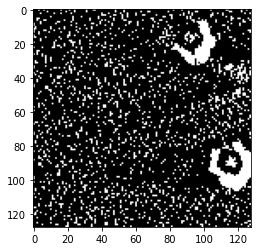

In [79]:
plt.imshow(masks[700],cmap='gray')

In [82]:
# define the parameters of images
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

In [83]:
# generating the model on our own
import tensorflow.keras as k

inputs = k.layers.Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))

s = k.layers.Lambda(lambda x: x)(inputs)  # transfer the data into float ! sometimes here should be divded with 255
c1 = k.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(s)  # kernel_init initilaize the parameters
c1 = k.layers.Dropout(0.1)(c1)
c1 = k.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = k.layers.MaxPooling2D((2,2))(c1)

# c1 - c5 are contraction paths
c2 = k.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = k.layers.Dropout(0.1)(c2)
c2 = k.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = k.layers.MaxPooling2D((2, 2))(c2)
 
c3 = k.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = k.layers.Dropout(0.2)(c3)
c3 = k.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = k.layers.MaxPooling2D((2, 2))(c3)
 
c4 = k.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = k.layers.Dropout(0.2)(c4)
c4 = k.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = k.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = k.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = k.layers.Dropout(0.3)(c5)
c5 = k.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = k.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = k.layers.concatenate([u6, c4])
c6 = k.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = k.layers.Dropout(0.2)(c6)
c6 = k.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = k.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = k.layers.concatenate([u7, c3])
c7 = k.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = k.layers.Dropout(0.2)(c7)
c7 = k.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = k.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = k.layers.concatenate([u8, c2])
c8 = k.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = k.layers.Dropout(0.1)(c8)
c8 = k.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = k.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = k.layers.concatenate([u9, c1], axis=3)
c9 = k.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = k.layers.Dropout(0.1)(c9)
c9 = k.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = k.layers.Conv2D(1, (1,1), activation='sigmoid')(c9)

In [84]:
# construct the model
model = k.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 128, 128, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

 conv2d_15 (Conv2D)             (None, 64, 64, 32)   9248        ['dropout_7[0][0]']              
                                                                                                  
 conv2d_transpose_3 (Conv2DTran  (None, 128, 128, 16  2064       ['conv2d_15[0][0]']              
 spose)                         )                                                                 
                                                                                                  
 concatenate_3 (Concatenate)    (None, 128, 128, 32  0           ['conv2d_transpose_3[0][0]',     
                                )                                 'conv2d_1[0][0]']               
                                                                                                  
 conv2d_16 (Conv2D)             (None, 128, 128, 16  4624        ['concatenate_3[0][0]']          
                                )                                                                 
          

In [87]:
# setting checkpoints

checkpointer = k.callbacks.ModelCheckpoint('checkpoints/model_for_synthetic.h5', verbose=1, save_best_only=True)
callbacks = [
    k.callbacks.EarlyStopping(patience=10, monitor='val_loss'),
    k.callbacks.TensorBoard(log_dir = 'logs')
]

X_train = images; Y_train = masks
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=25,callbacks=callbacks) # assign the param into models

Epoch 1/25
116/116 [==============================] - 4s 32ms/step - loss: 0.4044 - accuracy: 0.8599 - val_loss: 0.4085 - val_accuracy: 0.8578
Epoch 2/25
116/116 [==============================] - 4s 31ms/step - loss: 0.4043 - accuracy: 0.8598 - val_loss: 0.4089 - val_accuracy: 0.8578
Epoch 3/25
116/116 [==============================] - 4s 31ms/step - loss: 0.4040 - accuracy: 0.8600 - val_loss: 0.4086 - val_accuracy: 0.8578
Epoch 4/25
116/116 [==============================] - 4s 31ms/step - loss: 0.4038 - accuracy: 0.8600 - val_loss: 0.4090 - val_accuracy: 0.8578
Epoch 5/25
116/116 [==============================] - 4s 31ms/step - loss: 0.4035 - accuracy: 0.8602 - val_loss: 0.4093 - val_accuracy: 0.8578
Epoch 6/25
116/116 [==============================] - 4s 31ms/step - loss: 0.4032 - accuracy: 0.8602 - val_loss: 0.4091 - val_accuracy: 0.8578
Epoch 7/25
116/116 [==============================] - 4s 32ms/step - loss: 0.4029 - accuracy: 0.8604 - val_loss: 0.4090 - val_accuracy: 0.8578

In [91]:
# prdiction
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)

# preds_test = model.predict(X_test, verbose=1) #rui： need to update the X_test


7/7 [==============================] - 0s 15ms/step


In [9]:
# build the model with keras myself
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

In [10]:


outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)  # don't use sigmoid, direct output the dstribution

    model = Model(inputs, outputs, name="U-Net")
    return model

In [11]:
# print(datanames)
# print(type(temp))
# print(len(focal))
# print(len(GT))
# print(type(test[0]))
# print(test[1].shape)
# print(test[2].shape)
# print(len(test))
